In [1]:
!pip install -q stac-vrt

In [2]:
!rm -rf ./Satellite_ComputerVision

In [3]:
!git clone https://github.com/mjevans26/Satellite_ComputerVision.git

Cloning into 'Satellite_ComputerVision'...
remote: Enumerating objects: 968, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 968 (delta 147), reused 51 (delta 27), pack-reused 760
Receiving objects: 100% (968/968), 1.79 MiB | 6.88 MiB/s, done.
Resolving deltas: 100% (681/681), done.


In [2]:
import Satellite_ComputerVision.utils.pc_tools as pc_tools
import Satellite_ComputerVision.utils.raster_tools as raster_tools

from dask.distributed import Client
from dask_gateway import GatewayCluster
import stackstac
import pystac_client
import stac_vrt
import planetary_computer
from pyproj import CRS

import rasterio as rio
from rasterio.enums import Resampling
from rasterio.transform import Affine
from rasterio.windows import Window, from_bounds

import numpy as np
import pandas as pd
import geopandas as gpd
from random import randint

from azure.storage.blob import ContainerClient

filepath /home/jovyan/PlanetaryComputerExamples/Satellite_ComputerVision/utils/pc_tools.py
root /home/jovyan/PlanetaryComputerExamples/Satellite_ComputerVision/utils


In [5]:
raster_tools.convert_pt

<function Satellite_ComputerVision.utils.raster_tools.convert_pt(geometry: geopandas.geoseries.GeoSeries, out_crs: int, src_transform: list) -> tuple>

In [3]:
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [ ]:
cluster = GatewayCluster(shutdown_on_close = True)  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()
# cluster.scale(n = 16)
cluster.adapt(minimum=16, maximum=24)
print(cluster.dashboard_link)

In [4]:
bigshare_sas_token = 'sp=rl&st=2023-05-30T13:12:55Z&se=2023-05-30T21:12:55Z&sv=2022-11-02&sr=c&sig=bOPosP2yBmphRbOW26GQ%2BihnV%2B7LefNB3ymGo2Fmbmc%3D'
bigshare_string = f'https://cbpbigshare.blob.core.windows.net/batching?{bigshare_sas_token}'
landcover_sas_token = 'sp=racwl&st=2023-05-30T13:13:28Z&se=2023-05-30T21:13:28Z&sv=2022-11-02&sr=c&sig=elD3fHXU6ffrovrGlq%2FVmHliU0a043qdl8ib6ju%2FpDQ%3D'
landcover_ai_string = f'https://aiprojects.blob.core.windows.net/landcover_ai?{landcover_sas_token}'
container_client = ContainerClient.from_container_url(
    container_url = landcover_ai_string
)

In [37]:
# FOR FUTURE CONSISTENCY, WE INTEND TO RUN THIS ONLY ON COUNTIES WITH 2018 NAIP IMAGERY AND POINTS WITH LIDAR
# TO USE DASK, WE WILL GROUP BY CO_FIPS AND THIS FUNCTION MUST TAKE A PARTITION (i.e., dataframe)
def get_label_chip(row: pd.Series, baseUrl: str, window_size: int) -> np.ndarray:
    import rioxarray
    cofips = row['co_fips']
    pt = gpd.GeoSeries(row['geometry'], crs = 4326)
    url = f'{baseUrl}/{cofips}/{cofips}.vrt'
    #open reprojected vrt labels
    rst = rioxarray.open_rasterio(url)

    # save projection data for reprojected labels
    labCrs = rst.rio.crs
    labTransform = rst.rio.transform() 
    
    x, y = raster_tools.convert_pt(pt, labCrs, labTransform)
    x, y = np.rint(x), np.rint(y)
    x0, y0, x1, y1 = raster_tools.make_window(x, y, window_size = window_size)

    chip = rst[:,y0:y1,x0:x1]
    data = chip.rio.reproject(dst_crs = labCrs, shape = (600, 600), resampling = Resampling.nearest).values
    return data  

def export_chips_county(row: pd.Series, export: bool = True):
    import rioxarray
    import scipy
    # for each county
    #1. check if naip and lidar exist
    # FIRST WE GET THE CRS OF NAIP WITHIN THE COUNTY
    # url = row['url2'].iloc[0]
    exported = 0
    rand = randint(1, 10)
    if rand < 8:
        folder = 'train'
    else:
        folder = 'eval'
    lcdate = row['T2']
    cofips = row['co_fips']
    naipCrs = CRS(row['naipCrs'])
    idx = row.name
    pt = gpd.GeoSeries(row['geometry'], crs = 4326)
    box = gpd.GeoSeries(row['box'], crs = 4326)

    datetime = f'{lcdate}-01-01/{lcdate}-12-31'
    # Client.search() returns an ItemSearch object
    
    lcData = get_label_chip(row, 'https://aiprojects.blob.core.windows.net/landcover-ai/labels/reprojected', 360)
    luData = get_label_chip(row, 'https://aiprojects.blob.core.windows.net/landcover-ai/labels/lu/reprojected', 360)

    # now imagery from PC
    # NAIP
    try:
        print('retrieving NAIP data')
        naipSearch = catalog.search(
            intersects = box.iloc[0],
            datetime = datetime,
            collections = ['naip']
        )

        # items = [planetary_computer.sign(item).to_dict() for item in search.get_items()]
        items = pc_tools.recursive_api_try(naipSearch)
        # items = planetary_computer.sign(naipSearch.get_all_items())
        print('naip items are type:', type(items))

        # if items is a pystac ItemCollection
        items2 = items.to_dict()
        naip = items2['features']

        naipVrt = stac_vrt.build_vrt(naip, crs = naipCrs, block_width=512, block_height=512, data_type="Byte")
        naipRes = naip[0]['properties']['gsd'] # since we're using only 2018 counties, this should always be 0.6
        naipSide = int(360//naipRes) # thus, this should always be 600

        with rio.open(naipVrt) as src:
            naipCrs = src.crs
            naipTransform = src.transform
            x, y = raster_tools.convert_pt(pt, naipCrs, naipTransform)
            x, y = np.rint(x), np.rint(y)
            x0, y0, x1, y1 = raster_tools.make_window(x, y, window_size = naipSide)
            window = Window.from_slices((y0, y1), (x0, x1))
            naipData = src.read(window = window)
    
    except (ValueError, IndexError, AssertionError, RuntimeError) as msg:
        print(msg)
        naipData = np.zeros((1))
        pass
    
    try:
        # print('NAIP CRS', naipCrs)
        # ---LiDAR---
        print('retrieving LiDAR data')
        lidarSearch = catalog.search(
            intersects = box.iloc[0],
            datetime = '2017-01-01/2019-12-31', # we cast a broader temporal net for LiDAR
            collections = ['3dep-lidar-hag']
        )

        items = pc_tools.recursive_api_try(lidarSearch)
        # items = planetary_computer.sign(lidarSearch.get_all_items())
        print('lidar items are type:', type(items))
        # items is a pystac ItemCollection
        items2 = items.to_dict()
        lidar = items2['features']

        lidarUrl = lidar[0]['assets']['data']['href']
        lidarProperties = lidar[0]['properties']
        lidarCrs = lidarProperties['proj:projjson']['components'][0]['id']['code']
        lidarTransform = lidarProperties['proj:transform']
        lidarRes = lidarTransform[0]
        print('lidar resolution:', lidarRes)
        lidarSide = 360//lidarRes
        lidarZoom = round(600/lidarSide, 4)

        # lidarCrs = [asset['properties']['proj:projjson']['components'][0]['id']['code'] for asset in lidar]
        # print('LiDAR CRS', lidarCrs[0])
        lidarStac = stackstac.stack(
            lidar,
            # epsg = lidarCrs[0],
            epsg = lidarCrs,
            resolution = lidarRes)
            # resolution = 1)

        projected = lidarStac.rio.set_crs(lidarCrs)#[0])

        temporal = projected.median(dim = 'time') # xarray.DataArray
        lidarTransform = projected.attrs['transform']

        x, y = raster_tools.convert_pt(pt, lidarCrs, Affine(*lidarTransform[0:6]))
        x0, y0, x1, y1 = raster_tools.make_window(x, y, window_size = lidarSide)
        # print('getting lidar values')
        lidarChip = temporal[:,y0:y1, x0:x1].values
        # lidarChip = temporal[:,y0:y1, x0:x1].rio.set_crs(lidarCrs[0]).values
        # print('resampling lidar')
        lidarData = scipy.ndimage.zoom(lidarChip, order = 0, zoom = (1, lidarZoom, lidarZoom))
        # lidarData = lidarChip.rio.reproject(dst_crs = lidarCrs[0], shape = (600, 600), resampling = Resampling.nearest).values
     
            # check for all-nan lidar slice
        assert np.isfinite(np.sum(lidarData)), 'lidar chip contains Nan'
        
    except (ValueError, IndexError, AssertionError, RuntimeError) as msg:
        print(msg)
        lidarData = np.zeros((1))
        pass
    
            # ---Sentinel---

    # Client.search() returns an ItemSearch object
    try:
        search = catalog.search(
            intersects=box.iloc[0],
            datetime=datetime,
            collections=["sentinel-2-l2a"],
            limit=500,  # fetch items in batches of 500
            query={"eo:cloud_cover": {"lt": 10}},
        )

        s2items = [planetary_computer.sign(item).to_dict() for item in list(search.get_items())]
        s2 = s2items[0]
        s2epsg = s2['properties']['proj:epsg']
        s2Stac = (
            stackstac.stack(
                s2items,
                epsg = s2epsg,
                assets=["B02", "B03", "B04", "B08"],  # red, green, blue
                chunksize=4096,
                resolution=10,
            )
            .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
            .assign_coords({'band':['B2', 'B3', 'B4', 'B8']})  # use GEE names that model expects
        )

        # set spatial reference info
        s2crs = s2Stac.attrs['crs']
        s2projected = s2Stac.rio.set_crs(s2crs)
        s2transform = s2projected.attrs['transform']

        # split into bi-monthly collection & take median
        temporal = s2projected.resample(time = '2M', label = 'right', closed = 'left').median(dim = 'time')

        x, y = raster_tools.convert_pt(pt, s2crs, s2transform)
        x0, y0, x1, y1 = raster_tools.make_window(x, y, window_size = 36)
        clipped = temporal[:,:,y0:y1, x0:x1]

        s2Data = clipped.values
    
    except (ValueError, IndexError, AssertionError, RuntimeError) as msg:
        print(msg)
        s2Data = np.zeros((1))
        pass

    if export:
        # assert s2Data.shape == (28, 600, 600), f'data chips not expected size, shape: {chip.shape}'

        try:    
            naipBlob = f"naip_lidar_s2/data/{folder}/{cofips}_{lcdate}_naip_600x600_{idx}.npy"
            lidarBlob = f"naip_lidar_s2/data/{folder}/{cofips}_{lcdate}_lidar_600x600_{idx}.npy"
            lcBlob = f"naip_lidar_s2/data/{folder}/{cofips}_{lcdate}_label_600x600_{idx}.npy"
            luBlob = f"naip_lidar_s2/data/{folder}/{cofips}_{lcdate}_lu_600x600_{idx}.npy"
            s2Blob = f"naip_lidar_s2/data/{folder}/{cofips}_{lcdate}_s2_36x36_{idx}.npy"

    #         chip = np.concatenate([naipData, lidarData], axis = 0)
            assert s2Data.shape == (6, 4, 36, 36), f'sentinel chip no expected size, shape: {s2Data.shape}'
            print('exporting s2 data to', s2Blob)
            export_blob(s2Data, s2Blob)

            assert lcData.shape == (1, 600, 600), f'label chip not expected size, shape: {lcData.shape}'
            print('exporting land cover labels to', lcBlob)
            export_blob(lcData, lcBlob)

            assert luData.shape == (1, 600, 600), f'lu chip not expected size, shape: {luData.shape}'
            print('exporting land use labels to', luBlob)
            export_blob(luData, luBlob)

            assert naipData.shape == (4, 600, 600), f'naip chip not expected size, shape: {naipData.shape}'
            print('exporting naip data to', naipBlob)
            export_blob(naipData, naipBlob)

            assert lidarData.shape == (1, 600, 600), f'lidar chip not expected size, shape: {lidarData.shape}'
            print('exporting lidar data to', lidarBlob)
            export_blob(lidarData, lidarBlob)

            exported = 1
        except (AssertionError) as msg:
            print(msg)
            pass
        return exported
    else:
        return (clipped, naipData, lidarChip, lcData)

## Sampling

In [9]:
samplingPts = gpd.read_file(f'https://aiprojects.blob.core.windows.net/landcover-ai/samplingPts.geojson?{landcover_sas_token}')
samplingPts['box'] = samplingPts.to_crs('EPSG:3857').buffer(350).envelope.to_crs('EPSG:4326')
counties = gpd.read_file(f'https://aiprojects.blob.core.windows.net/landcover-ai/landcover_dates.geojson?{landcover_sas_token}')

In [10]:
counties.head()

,County,State,T1,T2,co_fips,fips,naipCrs,geometry
0,District of Columbia,DC,2013,2017,wash_11001,11001,26918,"POLYGON ((-76.95772 38.93080, -76.94192 38.918..."
1,Kent,DE,2013,2018,kent_10001,10001,26918,"POLYGON ((-75.76010 39.29682, -75.71490 39.299..."
2,New Castle,DE,2013,2018,newc_10003,10003,26918,"MULTIPOLYGON (((-75.56550 39.58797, -75.56493 ..."
3,Sussex,DE,2013,2018,suss_10005,10005,26918,"POLYGON ((-75.69878 38.52203, -75.70018 38.542..."
4,Allegany,MD,2013,2018,alle_24001,24001,26917,"POLYGON ((-78.72077 39.72303, -78.70645 39.722..."


In [11]:
# create the azure blob urls up front
def create_url(row, token):
    cofips = row['co_fips']
    LCDATE = row['T1']  
    LCDATE2 = row['T2']
    lcpath = f"https://cbpbigshare.blob.core.windows.net/batching/version2/{cofips}/output/{cofips}_landcover_{LCDATE}.tif?{token}"
    lcpath2 = f"https://cbpbigshare.blob.core.windows.net/batching/version2/{cofips}/input/{cofips}_landcover_{LCDATE2}.tif?{token}"
    lupath = f"https://cbpbigshare.blob.core.windows.net/batching/version2/{cofips}/output/{cofips}_lu_{LCDATE}.tif?{token}"
    lupath2 = f"https://cbpbigshare.blob.core.windows.net/batching/version2/{cofips}/output/{cofips}_lu_{LCDATE2}.tif?{token}"
    return pd.Series([lcpath, lcpath2, lupath, lupath2])

counties[['url', 'url2', 'LU_url', 'LU_url2']] = counties.apply(create_url, axis = 1, **{'token':bigshare_sas_token})

In [12]:
# join the county url's to the points
points = samplingPts[['geometry', 'box', 'lidar']].sjoin(counties[['geometry', 'url', 'LU_url', 'T1', 'url2', 'LU_url2', 'T2', 'co_fips', 'naipCrs']], how = 'left', predicate = 'within')

In [13]:
subset = points[(points['T2'] == '2018') & (points['lidar'] > 0)]
goodFips = subset['co_fips'].array.unique()
countySub = counties[counties['co_fips'].isin(goodFips)]
len(countySub)

48

### Inspect a test chip

In [12]:
i = randint(0, len(subset))
example = subset.iloc[i]

In [14]:
example = subset.iloc[1173]

In [38]:
test = export_chips_county(example, export = False)

retrieving NAIP data
naip items are type: <class 'pystac.item_collection.ItemCollection'>
retrieving LiDAR data
lidar items are type: <class 'pystac.item_collection.ItemCollection'>
lidar resolution: 2.0


/srv/conda/envs/notebook/lib/python3.10/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


lidar chip contains Nan


/srv/conda/envs/notebook/lib/python3.10/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


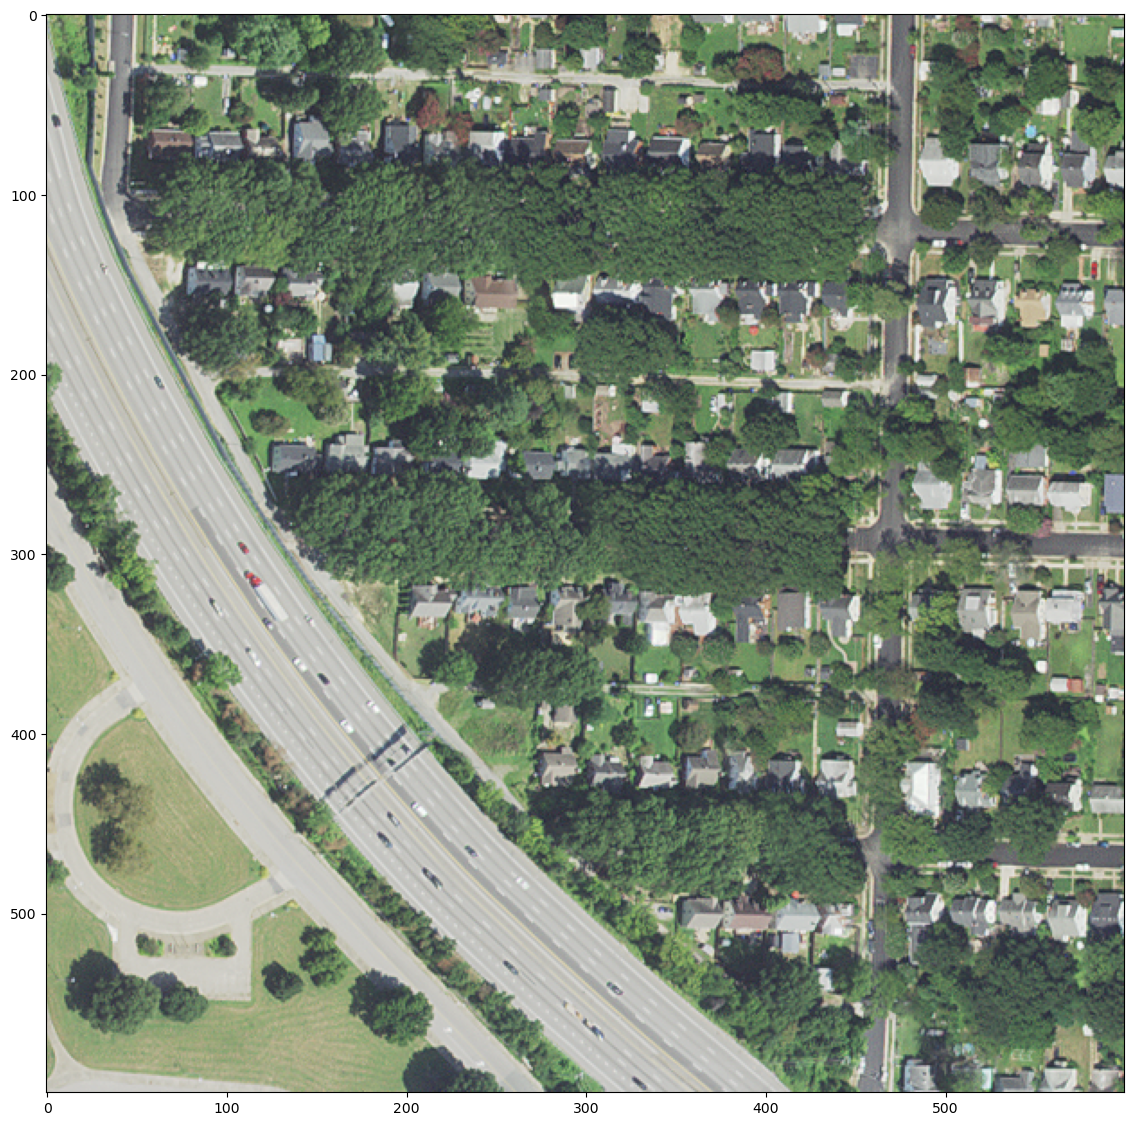

In [28]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
naipChip = np.moveaxis(test[1][0:3,:,:], 0, -1)/255.0
fig, ax = plt.subplots(figsize=(14, 14))

ax.imshow(naipChip)

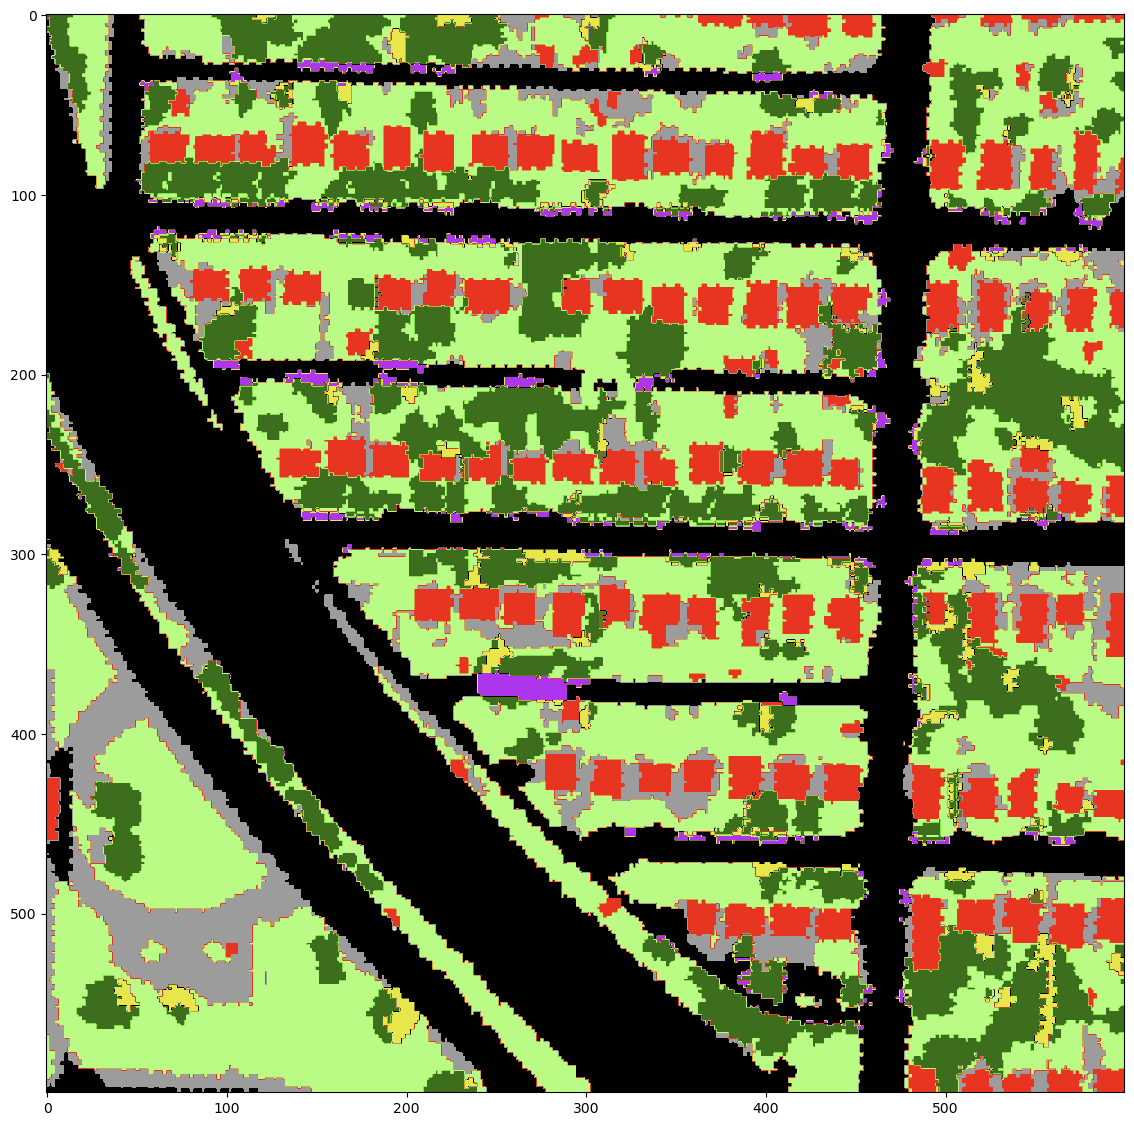

In [29]:
figure = plt.figure(figsize = (14,14))
# classes are
# 0 = water #5dc5f1 (light blue)
# 1 = wetland #50a886 (teal)
# 2 = tree #3d6e1d (dark green)
# 3 = shrubland #80e144 (light green)
# 4 = low veg #e7e64b (yellow)
# 5 = barren #d4a13e (burnt orange)
# 6 = structures #9c9c9c (grey)
# 7 = impervious #e73522 (red)
cmap = colors.ListedColormap(['#5dc5f1', '#50a886', '#3d6e1d', '#80e144', '#bafb85', '#d4a13e', "#e73522", "#9c9c9c", "#000000", "#706e22", "#e7e64b", "#fefc86", '#ad36ed'])
labelData = test[-1][-1,:,:]
plt.imshow(labelData.squeeze(), norm = colors.BoundaryNorm([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5, 9.5, 10.5, 11.5, 12.5], cmap.N), cmap = cmap)

In [30]:
test[2].shape

(1, 180, 180)

In [53]:
210+180+210

600

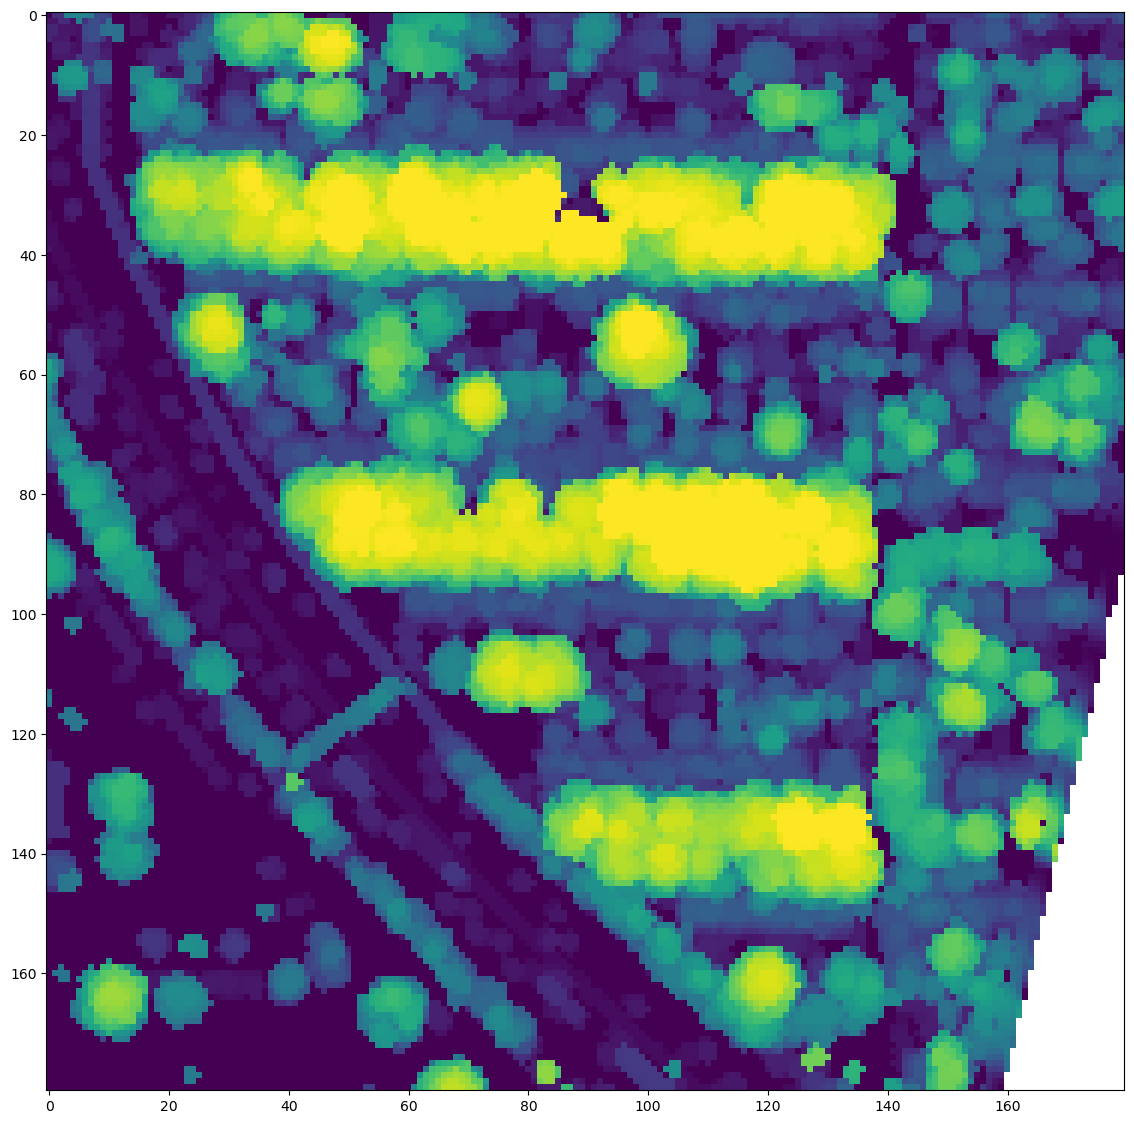

In [31]:
lidarData = test[2][0,:,:]
# pairs = [
#     ((-900, 1), (0, 0, 0, 0)),
#     ((1, 2), (205, 224, 241, 255)),
#     ((2, 3), (175, 209, 231, 255)),
#     ((3, 4), (137, 190, 220, 255)),
#     ((4, 5), (96, 166, 210, 255)),
#     ((5, 6), (34, 114, 181, 255)),
#     ((6, 7), (10, 84, 158, 255)),
#     ((7, 100), (8, 48, 107, 255)),
# ]


# intervals, color = zip(*pairs)
# nodes = np.array([x[1] for x in intervals]).astype(float)
# nodes -= np.abs(nodes.min())
# nodes /= nodes.max()


# color = [np.asarray(c) / 255 for c in color]

# cmap = colors.LinearSegmentedColormap.from_list(
#     "hag", list(zip(nodes, color))
# )

fig, ax = plt.subplots(figsize=(14, 14))

# # ax.imshow(cmap(lidarData.squeeze(), cmap=cmap)
# # ax.imshow(lidarData.squeeze(), vmin = 0, vmax = 100)
# import scipy
# result = scipy.ndimage.zoom(lidarData.squeeze(), 2)
ax.imshow(lidarData, vmin = 0, vmax = 25)

In [39]:
s2Data.crs

'epsg:32614'

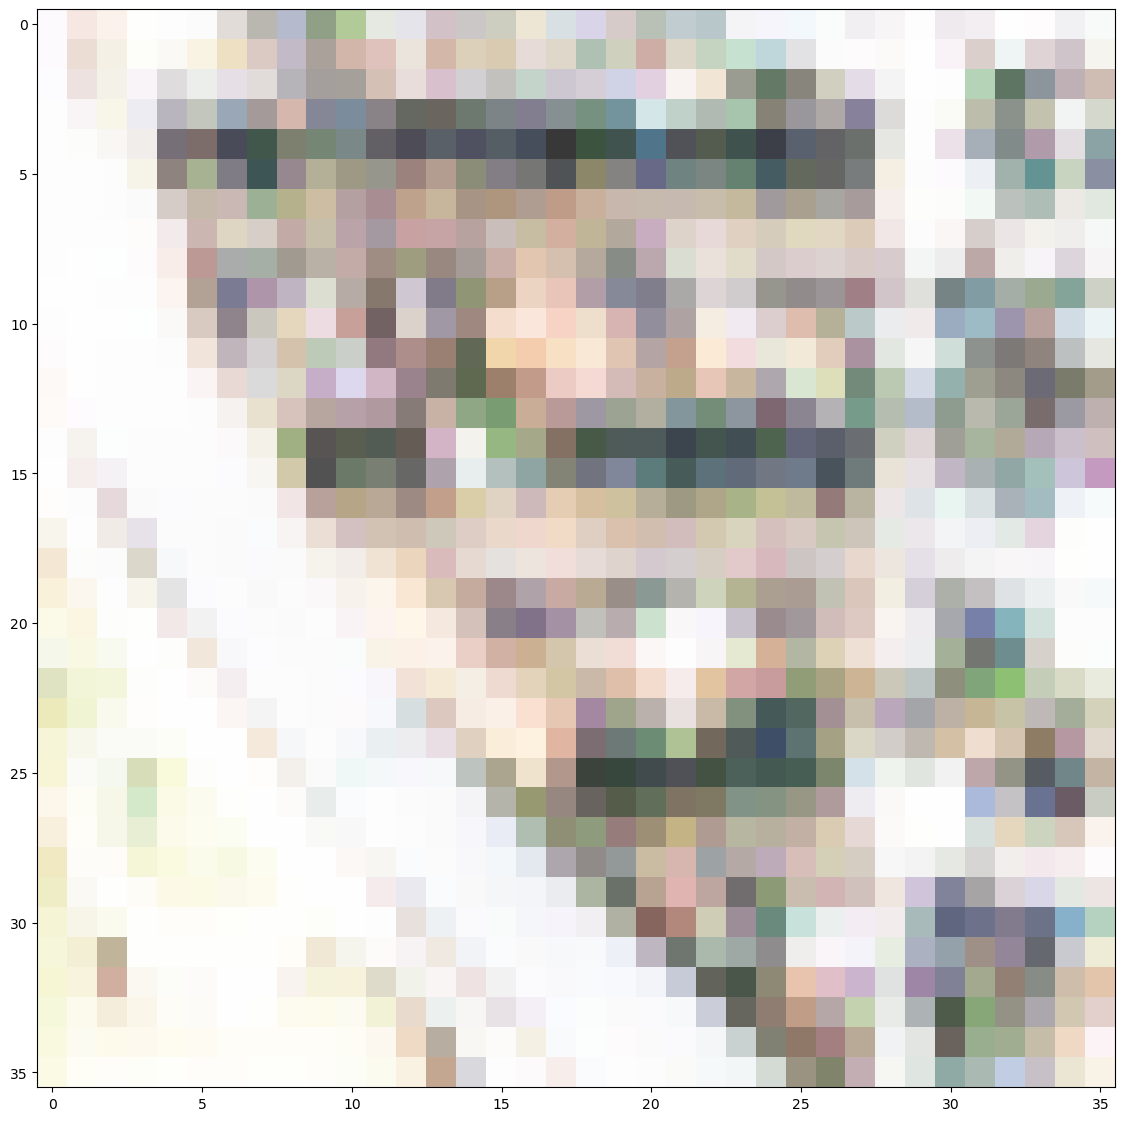

In [40]:
import xrspatial.multispectral as ms
s2Data = test[0][0]
tile = ms.true_color(*[s2Data[i,0:s2Data.shape[1],0:s2Data.shape[2]] for i in [2,1,0]])
# chipb = ms.true_color(r = medianb[2,0:test.shape[0],test.shape[1]], g = medianb[1,0:256,0:512], b = medianb[0,0:256,0:512])
# chipa = ms.true_color(r = mediana['B4'], g = mediana['B3'], b = mediana['B2'])
fig, ax = plt.subplots(figsize=(14, 14))

ax.imshow(tile)